In [1]:
using Pkg

using Flux
using MLDatasets
using Images
using Zygote
using Plots

Random.seed!(137)
# its not 42, but hopefully its good enough


In [2]:
train_X, train_y = MNIST(split=:train)[:]
test_X, test_y = MNIST(split=:test)[:]

# Normalize the images to the range [0, 1] and convert to Float32
train_X = Float32.(train_X ./ 255.0)
test_X = Float32.(test_X ./ 255.0)

# Reshape the data to match the expected input dimensions (length, channels, batch_size)
train_X = reshape(train_X, size(train_X, 1) * size(train_X, 2), 1, size(train_X, 3))
test_X = reshape(test_X, size(test_X, 1) * size(test_X, 2), 1, size(test_X, 3))

train_X = reshape(train_X, 28, 28, 1, size(train_X, 3))
test_X  = reshape(test_X, 28, 28, 1, size(test_X, 3))

;

In [20]:
model = Chain(
    Conv((3, 3), 1=>32, relu, pad=1),  # Increased filters
    MaxPool((2,2)),
    Conv((3,3), 32=>64, relu, pad=1),  # Increased filters
    MaxPool((2,2)),
    Flux.flatten,
    Dense(7*7*64, 256, relu),  # Increased neurons
    Dense(256, 7*7*64, relu),  # Increased neurons
    x -> reshape(x, (7, 7, 64, size(x, 2))),
    ConvTranspose((3, 3), 64=>32, relu, stride=2, pad=1),
    ConvTranspose((3, 3), 32=>1, σ, stride=2, pad=1),
    x -> reshape(x, :, size(x, 4)),
    Dense(25*25, 1),
    x -> reshape(x, size(x, 2))
)

;

In [21]:
loss(m, x, y) = mse(m(x), y)

opt = ADAM();

In [22]:
function train_model!(model, train_X, train_Y, opt, epochs, batch_size)
    data_loader = Flux.DataLoader((train_X, train_Y), batchsize=batch_size, shuffle=true)
    
    opt_state = Flux.setup(opt, model)  
    total_loss = []

    for epoch in 1:epochs
        epoch_loss = 0
        for (x, y) in data_loader
            gs = Flux.gradient(model -> Flux.Losses.mse(model(x), y), model)[1]  
            Flux.update!(opt_state, Flux.trainable(model), gs)
            epoch_loss += Flux.Losses.mse(model(x), y)
        end
        println("Epoch $epoch complete")
        push!(total_loss, epoch_loss)
    end
    return total_loss
end;

In [23]:
epochs = 10
batch_size = 64
;

In [24]:
loss_list = train_model!(model, train_X, train_y, opt, epochs, batch_size);

Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete


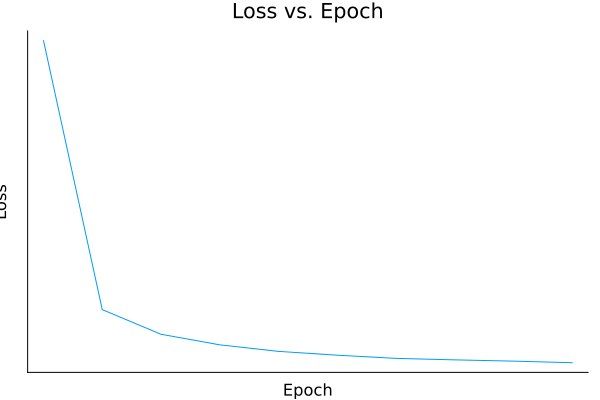

In [ ]:
p1 = plot(1:epochs, loss_list, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=false, yticks=false)
display(p1)

In [ ]:
input = rand(Float32, 28, 28, 1, 1)  # Single example

;

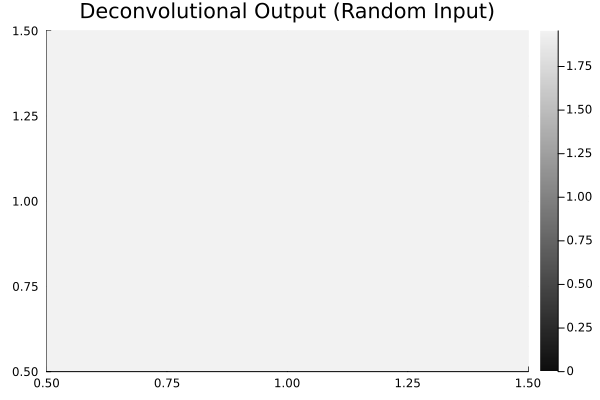

In [ ]:
output = model(input)

# Reshape for visualization (25x25 heatmap)
heatmap_data = reshape(model[10](model[9](input)), 25, 25)

# Plot heatmap
heatmap(heatmap_data, color=:viridis, title="Model Output Heatmap")
